The goal os `punk` is to make available sime wrappers for a variety of machine learning pipelines.

The pipelines are termed `primitves` and each primitive is designed with a functional programming approach in mind.

At the time of this writing, `punk` is being periodically updated. Any new primitives will be realesed as a pip-installable python package every friday along with their corresponding annotations files for the broader D3M community.

Here we will briefly show how the primitives in the punk package can be utilized.

In [1]:
import punk
help(punk)

Help on package punk:

NAME
    punk

PACKAGE CONTENTS
    base
    feature_selection (package)
    novelty_detection (package)
    utils (package)

DATA
    __all__ = ['feature_selection', 'novelty_detection', 'utils']

VERSION
    1.0.0

FILE
    /home/alarcj/Documents/datasci/NewKnowledge/primitives_repo/CODE/examples/punk/__init__.py




# Novelty Detection - Dataset Summarization

## Testing Heteroscedasticity

An interesting set we can do on our datasets is a test for Heteroscedasticity which may be able to tell us whether there are some subpopulations in our dataset (latent variables), sampling bias, or something of the sort. Future primitives will aid on this task.

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

from punk import novelty_detection

In [3]:
# Make some data up
n_samples, n_features, rank = 1000, 50, 10
sigma = 1.
rng = np.random.RandomState(42)
U, _, _ = linalg.svd(rng.randn(n_features, n_features))
X = np.dot(rng.randn(n_samples, rank), U[:, :rank].T)

# Adding homoscedastic noise
X_homo = X + sigma * rng.randn(n_samples, n_features)

# Adding heteroscedastic noise
sigmas = sigma * rng.rand(n_features) + sigma / 2.
X_hetero = X + rng.randn(n_samples, n_features) * sigmas

In [4]:
%%time

# run the primitive against a dataset with homocedatic noise 
test_homo = novelty_detection.HeteroscedasticityTest(max_iter=1000, tol=0.01)                
test_homo = test_homo.fit("matrix", X_homo)

CPU times: user 9.16 s, sys: 11.5 s, total: 20.7 s
Wall time: 6 s


In [5]:
%%time

# run the primitive against a dataset with homocedatic noise 
test_hetero = novelty_detection.HeteroscedasticityTest(max_iter=1000, tol=0.01)                
test_hetero = test_hetero.fit("matrix", X_hetero)

CPU times: user 8.43 s, sys: 9.96 s, total: 18.4 s
Wall time: 5 s


Notice that for Homoscedastic noise the difference between PCA and FactorAnalysis is relatively small and both are able to pick out a lower-rank principal subspace of dimensioanlity 10.

In the case of Nonisotropic noise FactorAnalysis does better than PCA and is able to get a much lower-rank subspace than PCA - 10 versus 40 dimensions.

In [6]:
print(test_homo.pca, test_homo.fa)
print(test_hetero.pca, test_hetero.fa)

(-74.953690343714229, 10) (-75.029704299751259, 10)
(-77.65986584714085, 40) (-76.948541495525788, 10)


### Compute Scores

The primitive `test_heteroscedasticity` is a wrapper for the function `compute_scores`. 
More details on this can be seen in [Model selection with Probabilistic PCA and FA](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_fa_model_selection.html).

In [7]:
scores = novelty_detection.HeteroscedasticityTest(max_iter=1000, tol=0.01)  

In [8]:
%%time
pca_scores_ho, fa_scores_ho = scores.compute_scores(X_homo)

CPU times: user 28min 42s, sys: 39min 36s, total: 1h 8min 19s
Wall time: 20min 23s


In [10]:
%%time
pca_scores_he, fa_scores_he = scores.compute_scores(X_hetero)

CPU times: user 27min 34s, sys: 40min 43s, total: 1h 8min 18s
Wall time: 20min 41s


In [30]:
pca_scores_ho, fa_scores_ho = novelty_detection.compute_scores(X_homo, max_iter=1000, tol=0.01)
pca_scores_he, fa_scores_he = novelty_detection.compute_scores(X_hetero, max_iter=1000, tol=0.01)

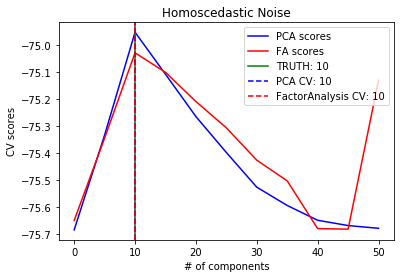

In [12]:
plt.plot([x for y, x in pca_scores_ho], [y for y, x in pca_scores_ho], 'b', label='PCA scores')
plt.plot([x for y, x in fa_scores_ho], [y for y, x in fa_scores_ho], 'r', label='FA scores')
plt.axvline(rank, color='g', label='TRUTH: %d' % rank, linestyle='-')
plt.axvline(test_homo.pca[1], color='b', label='PCA CV: %d' %test_homo.pca[1] , linestyle='--')
plt.axvline(test_homo.fa[1], color='r', label='FactorAnalysis CV: %d' % test_homo.fa[1], linestyle='--')

plt.xlabel("# of components")
plt.ylabel("CV scores")
plt.legend(loc="best")
plt.title("Homoscedastic Noise");

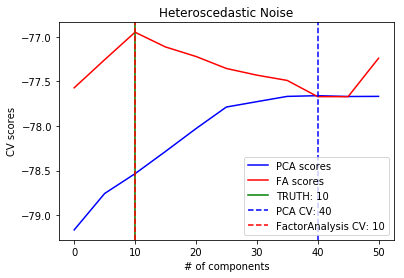

In [13]:
plt.plot([x for y, x in pca_scores_he], [y for y, x in pca_scores_he], 'b', label='PCA scores')
plt.plot([x for y, x in fa_scores_he], [y for y, x in fa_scores_he], 'r', label='FA scores')
plt.axvline(rank, color='g', label='TRUTH: %d' % rank, linestyle='-')
plt.axvline(test_hetero.pca[1], color='b', label='PCA CV: %d' %test_hetero.pca[1] , linestyle='--')
plt.axvline(test_hetero.fa[1], color='r', label='FactorAnalysis CV: %d'%test_hetero.fa[1], linestyle='--')

plt.xlabel("# of components")
plt.ylabel("CV scores")
plt.legend(loc="best")
plt.title("Heteroscedastic Noise");